# Predicting Credit Default Microfinance Loans in the Phillipines with BNK Bank

This project aims to predict credit default for a rural microfinance insitution in the Phillipines. The instution, Bangko Ng Kabuhayan, also know as BNK has three branches in areas outside of Manila. At the time this project was implemented, the bank had a significantly high defualt rate of nearly 50%. The aim of this project is the create an application which allows loan officers better predict credit default so that the bank can continue to stay in operation. 

We begin my importing and cleaning the neccesary data. 

In [1]:
import pandas as pd
import numpy as np 
import googlemaps


file = "/Users/jessicaparker/Desktop/Data/BNK Project/Jupyter Notebooks/Linear_Cleaned_Final_1.csv"
file_2 = "/Users/jessicaparker/Desktop/Data/BNK Project/Data/Leo_Logit_Files/logit_data_original.csv"
file_3 = "/Users/jessicaparker/Desktop/Data/BNK Project/Data/Leo_Logit_Files/logit_day4.csv"
file_4 = "/Users/jessicaparker/Desktop/Data/Usable_Data/Linear_Cleaned.csv"
file_5 = "/Users/jessicaparker/Desktop/Data/BNK Project/Data/New_Data/Linear_Industry.csv"
file_6 = "/Users/jessicaparker/Desktop/Data/Usable_Data/Linear_Excel/Linear_Adresses_1.csv"
# file_7 = 


mine_linear_o = pd.read_csv(file)
leo_logit_original_o = pd.read_csv(file_2)
leo_logit_clean_o = pd.read_csv(file_3)
linear_original_o = pd.read_csv(file_4)
linear_industry_o = pd.read_csv(file_5)
linear_addresses_o  = pd.read_csv(file_6)

mine_linear = mine_linear_o.copy()
leo_logit_original = leo_logit_original_o.copy()
leo_logit_clean = leo_logit_clean_o.copy()
linear_original = linear_original_o.copy()
linear_industry = linear_industry_o.copy()
linear_addresses = linear_addresses_o.copy()


## Dealing with INDUSTRY and Recombining/Encoding Columns

For our data, we had two main datasets with different features. 

Each of the datasets included various features. The features were encoded and combined accordingly.  
The industry column, belonging to the first dataset is cleaned below.  


In [2]:
linear_industry["INDUSTRY"] = linear_industry["INDUSTRY"].str.strip()
linear_industry["INDUSTRY"] = linear_industry["INDUSTRY"].apply(lambda x: "OTHER/UNKNOWN" if x!="RETAIL" and x!= "SERVICES" and x!= "MANUFACTURING" and x!= "WHOLESALE/RETAIL" else x)  
linear_industry["INDUSTRY"].value_counts()

RETAIL              518
SERVICES            209
OTHER/UNKNOWN        91
WHOLESALE/RETAIL     90
MANUFACTURING        57
Name: INDUSTRY, dtype: int64

As we can see here, the retail and services industry are the most popular. 

Below, we encoded the marital status column so that we can easily use it for one model later. A value of 0 signifies unmarried and 

In [3]:
leo_logit_clean.rename(columns = {'HOME_OWNED':'HOME OWNERSHIP'},inplace = True)
leo_logit_clean.drop('HOME_NOT_OWNED',inplace = True,axis = 1)

In [4]:
leo_logit_clean["CIVIL STATUS_MARRIED"] = leo_logit_clean["CIVIL STATUS_MARRIED"].replace(1,2)
leo_logit_clean["CIVIL STATUS_NON-MARRIED"] = leo_logit_clean["CIVIL STATUS_MARRIED"].replace(1,0)
leo_logit_clean["CIVIL STATUS"] = leo_logit_clean["CIVIL STATUS_MARRIED"] + leo_logit_clean["CIVIL STATUS_NON-MARRIED"]
leo_logit_clean["MARITAL STATUS"] = leo_logit_clean["CIVIL STATUS"].replace(4,1)

leo_logit_clean["MARITAL STATUS"] = leo_logit_clean["CIVIL STATUS"].replace(4,1)


## Combining Datasets 

Below the datasets are combined, but first we need to make sure that the column names match perfectly and that they have the same features. 

In [5]:
leo_logit_original["BRANCH"] = leo_logit_original["BRANCH"]


In [6]:
leo_logit_clean = leo_logit_clean.rename(columns=lambda x: x.strip())
mine_linear = mine_linear.rename(columns=lambda x: x.strip())


mine_linear["INDUSTRY"] = linear_industry["INDUSTRY"]
mine_linear.columns = map(str.upper, mine_linear.columns)
leo_logit_clean.columns = map(str.upper, leo_logit_clean.columns)

In [7]:
logit_filtered = leo_logit_clean[["TARGET",'LOAN', 'LOAN OUTSTANDING','CYCLE','AGE','GENDER','NUMBER OF DEPENDENTS',
                                 'HOME YEARS', 'YEARS','CF CALC','COLL CALC','CF TO LOAN','MOP_PDC',
                                 'MOP_WALK-IN','COLL 2 LOAN',"MARITAL STATUS","HOME OWNERSHIP","INDUSTRY"]]


In [8]:
linear_filtered = mine_linear[['TARGET','AMOUNT GRANTED','BALANCE','LOAN CYCLE','AGE','GENDER','DEPENDENTS',
                              'HOME LENGTH OF STAY','BUSINESS LENGTH OF STAY','CASHFLOW ENTITLEMENT','COLLATERAL AMOUNT',
                              'CF TO LOAN','MODE OF PAYMENT_PDC','MODE OF PAYMENT_WALK-IN','MARITAL STATUS','HOME OWNERSHIP',"INDUSTRY"]]


logit_filtered = logit_filtered.rename(columns = {"LOAN":"AMOUNT GRANTED",'NUMBER OF DEPENDENTS':'DEPENDANTS','HOME LENGTH OF STAY':'HOME YEARS',
                                'YEARS':"BUS YEARS",'CF CALC':"CASHFLOW",'COLL CALC':'COLLATERAL',
                                 "COLL 2 LOAN":"COLL TO LOAN","MARTIAL STATUS":"MARITAL"})
                                                  
linear_filtered = linear_filtered.rename(columns = {"LOAN CYCLE":"CYCLE",'YEARS':'BUS YEARS','CASHFLOW ENTITLEMENT':'CASHFLOW',
                                 'COLLATERAL AMOUNT':'COLLATERAL','MODE OF PAYMENT_PDC':'MOP_PDC',
                                 'MODE OF PAYMENT_WALK-IN':'MOP_WALK-IN',"BALANCE":"LOAN OUTSTANDING","DEPENDENTS":	"DEPENDANTS",
                                'HOME LENGTH OF STAY':'HOME YEARS',"BUSINESS LENGTH OF STAY": 'BUS YEARS'})


In [9]:
logit_filtered["INDUSTRY"].value_counts()

RETAIL              513
SERVICES            209
OTHERS               96
WHOLESALE/RETAIL     90
MANUFACTURING        57
Name: INDUSTRY, dtype: int64

### Calculating COLL TO LOAN for Linear Model

Since out first data set does not have the coll/loan feature, we calculated it below. 

In [10]:
linear_filtered['COLL TO LOAN'] = linear_filtered["CASHFLOW"]/linear_filtered['AMOUNT GRANTED']

### Merging the Datasets

In [11]:
merged = pd.concat([linear_filtered, logit_filtered], axis=0)

## Making Dummies and Shuffling the Dataset 

Next we made dummies for the "INDUSTRY" column. This was eventually excluded from our analysis since we found this feature to be insignificant. 
Afterwards, the combined dataset is shuffled so that rows appear in random order and the data is mixed between the two initial datasets. 

In [12]:
merged_dum  = pd.get_dummies(data = merged, columns = ["INDUSTRY"])
merged_shuff = merged_dum.sample(frac=1).reset_index(drop=True)

# Elementary Modeling 

Here we used a simply Random Forest Classifier. We did not include any columns relating to the bank branch or client's industry since we found these features to be insignificant. Below we check and make sure that we do not have any missing values. 

In [13]:
merged_shuff[['CYCLE', 'HOME YEARS', 'AGE','BUS YEARS', 
          'CF TO LOAN', 'COLL TO LOAN',"AMOUNT GRANTED", "MARITAL STATUS", "HOME OWNERSHIP","MOP_WALK-IN","GENDER"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CYCLE           2024 non-null   float64
 1   HOME YEARS      2024 non-null   float64
 2   AGE             2024 non-null   float64
 3   BUS YEARS       2024 non-null   float64
 4   CF TO LOAN      2024 non-null   float64
 5   COLL TO LOAN    2024 non-null   float64
 6   AMOUNT GRANTED  2024 non-null   float64
 7   MARITAL STATUS  2024 non-null   int64  
 8   HOME OWNERSHIP  2024 non-null   int64  
 9   MOP_WALK-IN     2024 non-null   int64  
 10  GENDER          2024 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 174.1 KB


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X = merged_shuff[['CYCLE', 'HOME YEARS', 'AGE','BUS YEARS', 
          'CF TO LOAN', 'COLL TO LOAN',"AMOUNT GRANTED", "MARITAL STATUS", "HOME OWNERSHIP","MOP_WALK-IN","GENDER"]]

y = merged_shuff["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

forest = RandomForestClassifier(n_estimators = 10)

forest.fit(X_train, y_train)
forest.score(X_test, y_test)



0.7114624505928854

Below we can see the feature importances of the ones that we included in the model. Each features is graphed as its percentage of importance when included with the other features. As you can see, marital status has the lowest importance while the amount granted to the client has the highest. 

In [15]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': forest.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

,feature,importance
6,AMOUNT GRANTED,0.216010
5,COLL TO LOAN,0.146713
4,CF TO LOAN,0.138113
1,HOME YEARS,0.114460
2,AGE,0.099880
3,BUS YEARS,0.089464
0,CYCLE,0.089348
9,MOP_WALK-IN,0.036929
8,HOME OWNERSHIP,0.027556
10,GENDER,0.022983


## Simple Log Model 

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_model = LogisticRegression()

log_model.fit(X_train, y_train)
log_score = log_model.score(X_test, y_test)
y_pred = log_model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73       271
         1.0       0.71      0.55      0.62       235

    accuracy                           0.69       506
   macro avg       0.69      0.68      0.68       506
weighted avg       0.69      0.69      0.68       506



In our case of predicting if a loan would default - It would be better to have a high Recall as the banks don't want to lose money and would be a good idea to alarm the bank even if there is a slight doubt about defaulter.
Low precision, in this case, might be okay. However, we experiemented with other models and optimized them to see if we could achieve higher accuracy.

# XG Boost Model

In [17]:
import warnings
from scipy.stats import randint
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore")

xgb = XGBClassifier()
search_space = {'max_depth':randint(2,25), 
                'n_jobs':randint(2,100),"n_estimators":randint(2,150)}

search = RandomizedSearchCV(xgb, param_distributions = search_space, n_jobs=-1, 
                            scoring = 'f1', cv = 10, n_iter = 10)

# Fit search
search.fit(X_train,y_train)

#Best parameters
search.best_params_
xg_model = search.best_estimator_

xg_model.fit(X_train, y_train)
boost_score = xg_model.score(X_test,y_test)
boost_score

0.7430830039525692

As we can see here, the accuracy doesn't change much from our previous log model. Below, we plot the learning curves. This is done to ensure that the model is not overfitting and we can genelize well with our test data. Since the mean squared error for our test data is increasing and remaining static for our training data, then we can safely assume that we are not overfitting. 

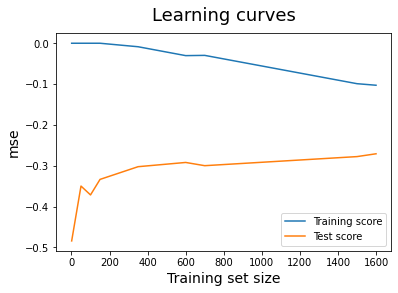

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = xg_model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [1,50,150,350,600,700,100,1500,1600], cv = 5,
                                                              scoring = 'neg_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('mse', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

## Random Forest Randomized Search CV 

We did some research and discovered that the Random Forest Classifier is frequently used to predict credit default, so we decided to give it a go. We also used RandomizedSearchCV so that we could get the model with the most accuracy parameters. 

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


forest = RandomForestClassifier()
search_space = {'min_samples_split' : randint(2,25), 'max_depth':randint(2,25), 
                'n_jobs':randint(2,100),"n_estimators":randint(2,150)}

search = RandomizedSearchCV(forest, param_distributions = search_space, n_jobs=-1, 
                            scoring = 'f1', cv = 10, n_iter = 10)

# Fit search
search.fit(X_train,y_train)

#Best parameters
search.best_params_
model = search.best_estimator_

model.fit(X_train, y_train)
f_score = model.score(X_test,y_test)
f_score

0.7450592885375494

<AxesSubplot:>

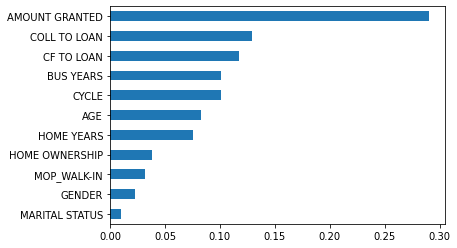

In [20]:
import matplotlib.pyplot as plt 

fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi
# y_pred = model.predict(X_test)

(pd.Series(model.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh'))

In [21]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

,feature,importance
6,AMOUNT GRANTED,0.290275
5,COLL TO LOAN,0.128877
4,CF TO LOAN,0.117571
3,BUS YEARS,0.101073
0,CYCLE,0.100876
2,AGE,0.082520
1,HOME YEARS,0.075891
8,HOME OWNERSHIP,0.037851
9,MOP_WALK-IN,0.031988
10,GENDER,0.022939


Below, we tried a Naive Bayes Classifier. However, Random Forest accuracy triumphs this model.  

## Naive Bayes 

In [22]:
from sklearn.naive_bayes import MultinomialNB

#Create a Gaussian Classifier
bayes = MultinomialNB()

# Train the model using the training sets
# model.fit(X_train,y_train)
# model.score(X_test,y_test)
#Predict Output
# predicted= model.predict([[0,2]]) # 0:Overcast, 2:Mild
# print "Predicted Value:", predicted

search_space = {"alpha":  np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])}

search = RandomizedSearchCV(bayes, param_distributions = search_space)

# Fit search
search.fit(X_train,y_train)

#Best parameters
search.best_params_
bayes_model = search.best_estimator_

bayes_model.fit(X_train, y_train)
b_score = bayes_model.score(X_test,y_test)

## Model Comparison

In [35]:
mc = pd.DataFrame({'model': ["Log Model","Random Forest", "Naive Bayes","XGBoost",],
                   'accuracy': [log_score, f_score, b_score , boost_score] }).\
                    sort_values('accuracy', ascending = False)

In [36]:
mc

,model,accuracy
1,Random Forest,0.745059
3,XGBoost,0.743083
0,Log Model,0.685771
2,Naive Bayes,0.685771


## Feature Selection 

Below are the feature importances that were retrived from the Random Forest Model

In [25]:
fi

,feature,importance
6,AMOUNT GRANTED,0.290275
5,COLL TO LOAN,0.128877
4,CF TO LOAN,0.117571
3,BUS YEARS,0.101073
0,CYCLE,0.100876
2,AGE,0.082520
1,HOME YEARS,0.075891
8,HOME OWNERSHIP,0.037851
9,MOP_WALK-IN,0.031988
10,GENDER,0.022939


Since there seems to be a significant drop off after Home Years, we will exclude the following variables, home ownership, gender, and marital status then see how our accuracy changes. 

### Log Model

In [39]:
X_train = X_train[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]
X_test = X_test[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]



log_modelcv = LogisticRegression()
search_space = {'n_jobs':randint(2,100), 
                'max_iter':randint(2,100)}

search = RandomizedSearchCV(log_modelcv, param_distributions = search_space, n_jobs=-1, 
                            scoring = 'f1')

# Fit search
search.fit(X_train,y_train)

#Best parameters
search.best_params_
model = search.best_estimator_

model.fit(X_train, y_train)
log_score_2 = model.score(X_test,y_test)
log_score_2

0.4644268774703557

### Random Forest 

In [26]:
X_train = X_train[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]
X_test = X_test[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]

model.fit(X_train, y_train)
f_score_2 = model.score(X_test, y_test)



### XG Boost

In [27]:
X_train = X_train[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]
X_test = X_test[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]

xg_model.fit(X_train, y_train)
boost_score_2 = xg_model.score(X_test, y_test)

### Naive Bayes

In [28]:
X_train = X_train[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED', ]]
X_test = X_test[['CYCLE', 'HOME YEARS', 'AGE', 'BUS YEARS', 'CF TO LOAN', 'COLL TO LOAN',
       'AMOUNT GRANTED']]

bayes_model.fit(X_train, y_train)
b_score_2 = bayes_model.score(X_test,y_test)

In [42]:
mc_2 = pd.DataFrame({'model': ["Logistic Model","Random Forest", "Naive Bayes","XGBoost"],
                   'accuracy': [log_score_2,f_score_2, b_score_2 , boost_score_2] }).\
                    sort_values('accuracy', ascending = False)

mc_2

,model,accuracy
1,Random Forest,0.768775
3,XGBoost,0.756917
2,Naive Bayes,0.687747
0,Logistic Model,0.464427


After choosing the features that are significant, we can see that the Random Forest Model preforms the best. 

In [30]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78       271
         1.0       0.75      0.76      0.75       235

    accuracy                           0.77       506
   macro avg       0.77      0.77      0.77       506
weighted avg       0.77      0.77      0.77       506



We were able to increase not only the precision score, but also the recall score for a hirer overall accuracy. 

## Check for Overfitting 

While higher accuracy is what is desired, we need to make sure that our model is not overfitting. That means that our model should not git the training data too well to the point where it is unable to use general data to make predictions. 

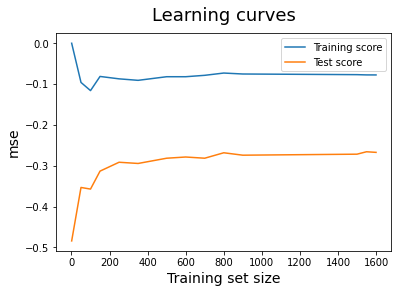

In [31]:

train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [1,50,150,250,350,500,600,700,800,900,100,1500,1550,1600], cv = 5,
                                                              scoring = 'neg_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('mse', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

The learning curves here indicate that we are not overfitting, however we would benefit from increasing the size of our training data! 

## Visualizations 

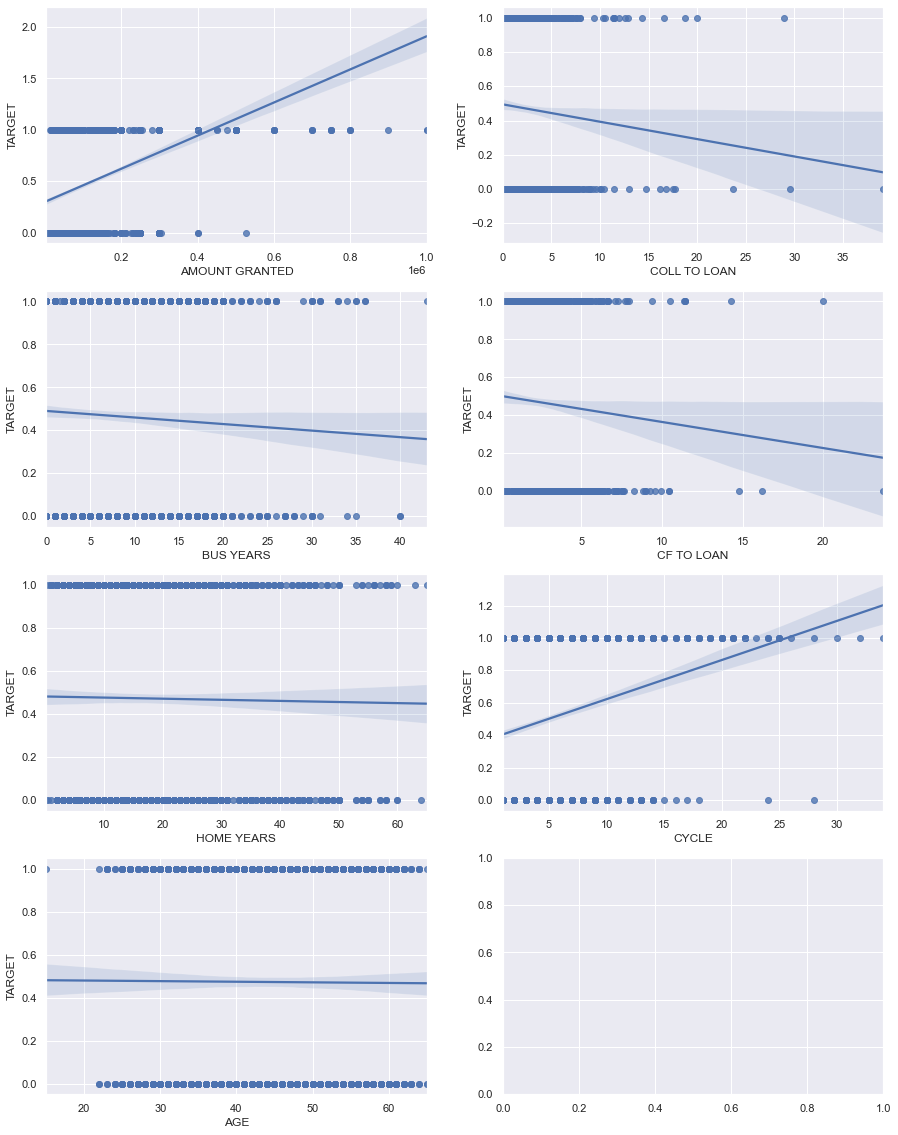

In [32]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,20)})
fig, axs = plt.subplots(nrows = 4, ncols = 2)

sns.regplot(x='AMOUNT GRANTED', y=y, data=merged_shuff, ax=axs[0][0],label="Amount Granted" )
sns.regplot(x='BUS YEARS', y=y, data= merged_shuff , ax=axs[1][0])
sns.regplot(x='HOME YEARS', y=y, data= merged_shuff , ax=axs[2][0])
sns.regplot(x='AGE',y=y, data=merged_shuff, ax=axs[3][0])
# sns.regplot(x='BUS YEARS', y=y, data= merged_shuff , ax=axs[4][0])
sns.regplot(x='COLL TO LOAN',y=y, data=merged_shuff, ax=axs[0][1])
sns.regplot(x='CF TO LOAN', y=y, data= merged_shuff , ax=axs[1][1])
sns.regplot(x='CYCLE', y=y, data= merged_shuff , ax=axs[2][1])
plt.savefig("target_relationships.png")


In [33]:
merged_shuff.to_csv(r'/Users/jessicaparker/Desktop/Data/Usable_Data/MERGED.csv', index = True)
